# 1. Install stuff

In [ ]:
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install numpy opencv-python matplotlib modelbit streamlit streamlit_image_coordinates watchdog
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu # Linux - CPU

# %pip install torch torchvision

In [60]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# 2. Imports

In [9]:
from segment_anything import SamPredictor, sam_model_registry
import os
import cv2
import numpy as np
import base64

import matplotlib.pyplot as plt

# 3. Research 
### Define segmentation model

In [18]:
model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)

### Read test image

(-0.5, 1599.5, 1199.5, -0.5)

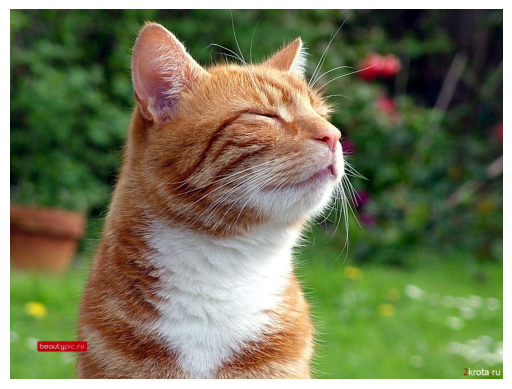

In [37]:
image_path = './test5.jpg'
x = 528
y = 606

image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')

### Run inference on test image

In [16]:
predictor.set_image(image)

masks, scores, logits = predictor.predict(
                                  point_coords=np.asarray([[x, y]]),
                                  point_labels=np.asarray([1]),
                                  multimask_output=True
                              )

C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)

for j in range(C):
  result_mask |= masks[j, :, :]

result_mask = result_mask.astype(np.uint8)


### Get segmentation mask of main subject in the image

In [26]:
predictor.set_image(image)
masks, scores, logits = predictor.predict(point_coords=np.asarray([[x, y]]),
                  point_labels=np.array([1]),
                  multimask_output=True)
C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)

for j in range(C):
    result_mask |= masks[j, :, :]
result_mask = result_mask.astype(np.uint8)

### Isolate the subject

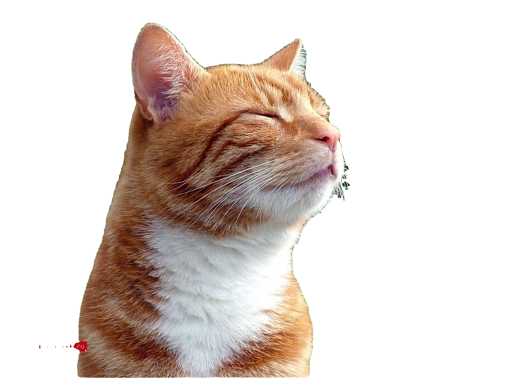

In [48]:
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
plt.savefig("test5_result.png", bbox_inches='tight')

### Remove white background

In [50]:
def cut(img):
  # crop image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  cnts, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = sorted(cnts, key=cv2.contourArea)[-1]
  x,y,w,h = cv2.boundingRect(cnt)
  new_img = img[y:y+h, x:x+w]

  return new_img        

In [ ]:
def transparentBackground(img):   
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  roi, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  mask = np.zeros(img.shape, img.dtype)

  cv2.fillPoly(mask, roi, (255,)*img.shape[2], )

  masked_image = cv2.bitwise_and(img, mask)

  return masked_image

True

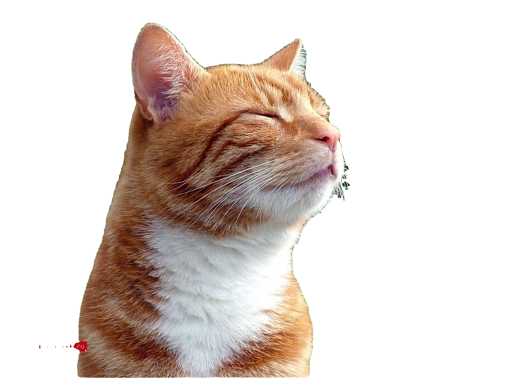

In [55]:
result_image = cut(result_image)

result_image = transparentBackground(result_image)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
cv2.imwrite("test5_result.webp", result_image)


# 4. Functionalise workflow

### Prepare model for deployment

#### Run just this cell to skip straight to deployment

In [53]:
import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)
x = 528
y = 606


def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                    point_coords=np.asarray([[x, y]]),
                                    point_labels=np.asarray([1]),
                                    multimask_output=True
                                )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype=bool)

  for j in range(C):
    result_mask |= masks[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))
  result_image = cut(result_image)
  result_image = transparentBackground(result_image)

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64
     

### Test remove_background()

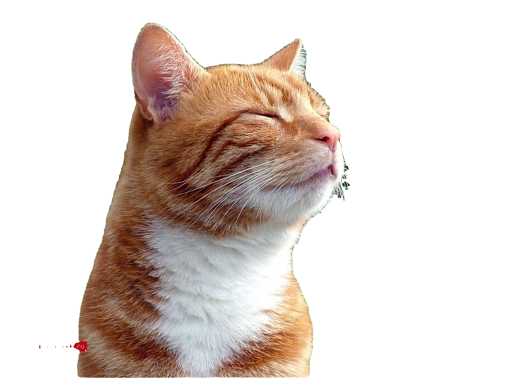

In [54]:
import matplotlib.pyplot as plt

image = cv2.imread('test5.jpg')
_, image_bytes = cv2.imencode('.png', image)
image_bytes = image_bytes.tobytes()
image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')


fn_result = remove_background(image_bytes_encoded_base64, x, y)

fn_result_bytes = base64.b64decode(fn_result)
fn_result_image = cv2.imdecode(np.frombuffer(fn_result_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(fn_result_image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
plt.show()

# 5. Deployment
### Login to Modelbit

In [30]:
import modelbit
mb = modelbit.login()

In [31]:
mb.deploy(remove_background)

Uploading 'predictor': 100%|██████████| 348M/348M [00:26<00:00, 13.3MB/s] 


In [ ]:
api_endpoint = '' # Get from dashboard

### Test API endpoint

In [23]:
import requests
import matplotlib.pyplot as plt

In [ ]:
image_path = 'test5.jpg'
x = 528
y = 606

image = cv2.imread(image_path)
_, image_bytes = cv2.imencode('.png', image)
image_bytes = image_bytes.tobytes()
image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

api_data = {'data': [image_bytes_encoded_base64, x, y]}
response = requests.post(api_endpoint, json=api_data)

# response = modelbit.get_inference(
#   workspace="",
#   deployment="",
#   data=[image_bytes_encoded_base64, x, y]
# )

print(response.text)

api_result_image = response.json()['data']

api_result_bytes = base64.b64decode(api_result_image)
api_result_image = cv2.imdecode(np.frombuffer(api_result_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(api_result_image, cv2.COLOR_BGRA2RGBA))
plt.show()